# Tensorgrad Demo: Training a MLP on MNIST

In [1]:
import sys
import gzip
import struct
import urllib.request
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

ROOT = Path.cwd().resolve().parents[0]
sys.path.insert(0, str(ROOT))

from tensorgrad.tensor import Tensor, no_grad
from tensorgrad.data import TensorDataset, DataLoader
from tensorgrad.nn import Sequential, ReLU, CrossEntropyLoss, Linear
from tensorgrad.optim import AdamW
from tensorgrad.training import fit
from tensorgrad.lr_scheduler import ReduceLROnPlateau

In [2]:
DATA_DIR = ROOT / "demos" / "data" / "mnist"

URLS = {
    "train_images": "https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz",
    "train_labels": "https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz",
    "test_images":  "https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz",
    "test_labels":  "https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz",
}

DATA_DIR.mkdir(parents=True, exist_ok=True)

def download(url, dest):
    if dest.exists():
        return
    print(f"Downloading {url} -> {dest}")
    urllib.request.urlretrieve(url, dest)
    print("Download complete!")

def load_images(path):
    with gzip.open(path, "rb") as f:
        magic, n, rows, cols = struct.unpack(">IIII", f.read(16))
        assert magic == 2051, f"Bad magic {magic} for images"
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data.reshape(n, rows, cols)

def load_labels(path):
    with gzip.open(path, "rb") as f:
        magic, n = struct.unpack(">II", f.read(8))
        assert magic == 2049, f"Bad magic {magic} for labels"
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data.reshape(n,)

In [3]:
for key, url in URLS.items():
    download(url, DATA_DIR / Path(url).name)

Download complete!
Download complete!
Download complete!
Download complete!


In [4]:
# Load and preprocess images
train_data = load_images(DATA_DIR / "train-images-idx3-ubyte.gz")
train_labels = load_labels(DATA_DIR / "train-labels-idx1-ubyte.gz")
val_data  = load_images(DATA_DIR / "t10k-images-idx3-ubyte.gz")
val_labels  = load_labels(DATA_DIR / "t10k-labels-idx1-ubyte.gz")

train_data = (train_data.astype(np.float32) / 255.0).reshape(-1, 28 * 28)
val_data  = (val_data.astype(np.float32) / 255.0).reshape(-1, 28 * 28)

In [ ]:
device = "cpu"      # should be cpu or cuda

X_train = Tensor(train_data, requires_grad=False, device=device)
y_train = Tensor(train_labels, requires_grad=False, device=device)

X_val  = Tensor(val_data, requires_grad=False, device=device)
y_val  = Tensor(val_labels, requires_grad=False, device=device)

train_ds = TensorDataset(X_train, y_train)
val_ds  = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, drop_last=False)
val_loader  = DataLoader(val_ds, batch_size=256, shuffle=False, drop_last=False)

In [6]:
# MLP model
model = Sequential(
    Linear(28 * 28, 128),
    ReLU(),
    Linear(128, 10),
)

model.to(device=device);

In [7]:
# Train the Model
loss_fn = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler = ReduceLROnPlateau(
    optimizer,
    factor=0.5,
    patience=2,
    threshold=1e-3,
    min_lr=1e-6,
)

num_epochs = 20

history = fit(
    model=model,
    train_loader=train_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    num_epochs=num_epochs,
    val_loader=val_loader,
    scheduler=scheduler,
)

Epoch 1/20, lr=0.001 Train: 0.3586 (94.50%)  Val: 0.1997 (94.25%)
Epoch 2/20, lr=0.001 Train: 0.1615 (96.66%)  Val: 0.1337 (96.07%)
Epoch 3/20, lr=0.001 Train: 0.1137 (97.46%)  Val: 0.1098 (96.86%)
Epoch 4/20, lr=0.001 Train: 0.0882 (98.10%)  Val: 0.0968 (97.12%)
Epoch 5/20, lr=0.001 Train: 0.0703 (98.42%)  Val: 0.0833 (97.58%)
Epoch 6/20, lr=0.001 Train: 0.0579 (98.64%)  Val: 0.0811 (97.60%)
Epoch 7/20, lr=0.001 Train: 0.0479 (98.97%)  Val: 0.0776 (97.60%)
Epoch 8/20, lr=0.001 Train: 0.0405 (98.91%)  Val: 0.0762 (97.69%)
Epoch 9/20, lr=0.001 Train: 0.0341 (99.38%)  Val: 0.0734 (97.83%)
Epoch 10/20, lr=0.001 Train: 0.0285 (99.50%)  Val: 0.0708 (97.95%)
Epoch 11/20, lr=0.001 Train: 0.0243 (99.59%)  Val: 0.0685 (97.94%)
Epoch 12/20, lr=0.001 Train: 0.0203 (99.67%)  Val: 0.0697 (98.05%)
Epoch 13/20, lr=0.001 Train: 0.0167 (99.61%)  Val: 0.0740 (97.86%)
Epoch 14/20, lr=0.0005 Train: 0.0155 (99.85%)  Val: 0.0682 (97.92%)
Epoch 15/20, lr=0.0005 Train: 0.0093 (99.94%)  Val: 0.0656 (98.13%)
Ep

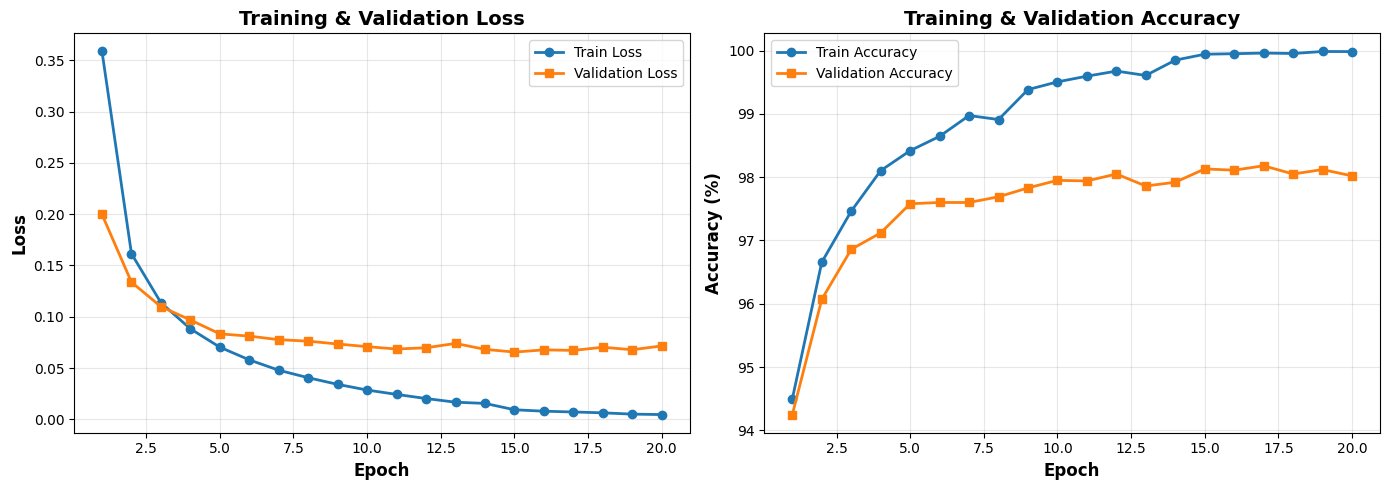

In [8]:
# Plot Training Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, num_epochs+1)

# Loss plot
ax1.plot(epochs, history["train_loss"], 'o-', label='Train Loss', linewidth=2, markersize=6)
ax1.plot(epochs, history["val_loss"], 's-', label='Validation Loss', linewidth=2, markersize=6)
ax1.set_xlabel('Epoch', fontweight='bold', fontsize=12)
ax1.set_ylabel('Loss', fontweight='bold', fontsize=12)
ax1.set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(epochs, history["train_acc"], 'o-', label='Train Accuracy', linewidth=2, markersize=6)
ax2.plot(epochs, history["val_acc"], 's-', label='Validation Accuracy', linewidth=2, markersize=6)
ax2.set_xlabel('Epoch', fontweight='bold', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontweight='bold', fontsize=12)
ax2.set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
# Generate Confusion Matrix
model.eval()
confusion = np.zeros((10, 10), dtype=int)

with no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)

        pred = outputs.data.argmax(axis=1)
        true = labels.data.astype(int)

        for t, p in zip(true, pred):
            confusion[int(t), int(p)] += 1

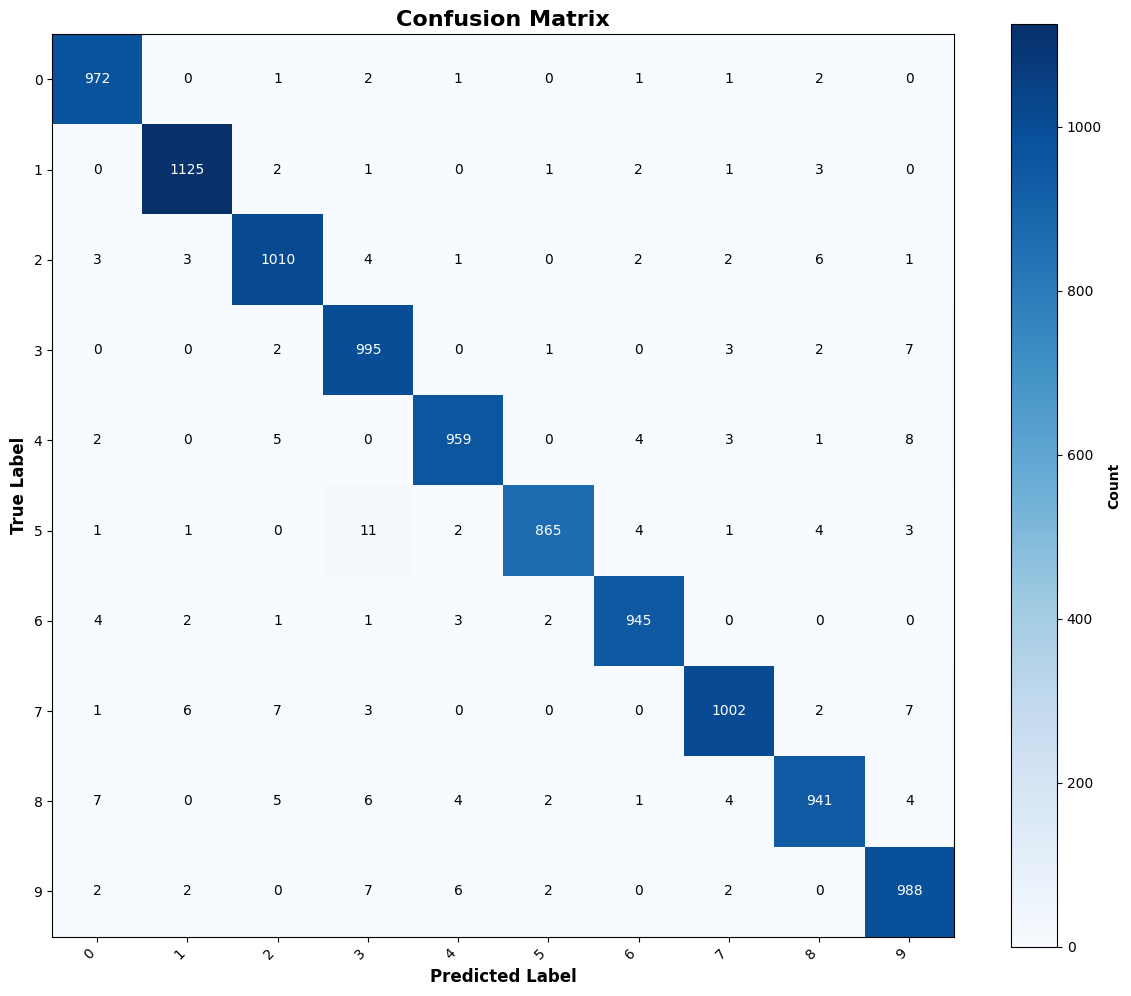

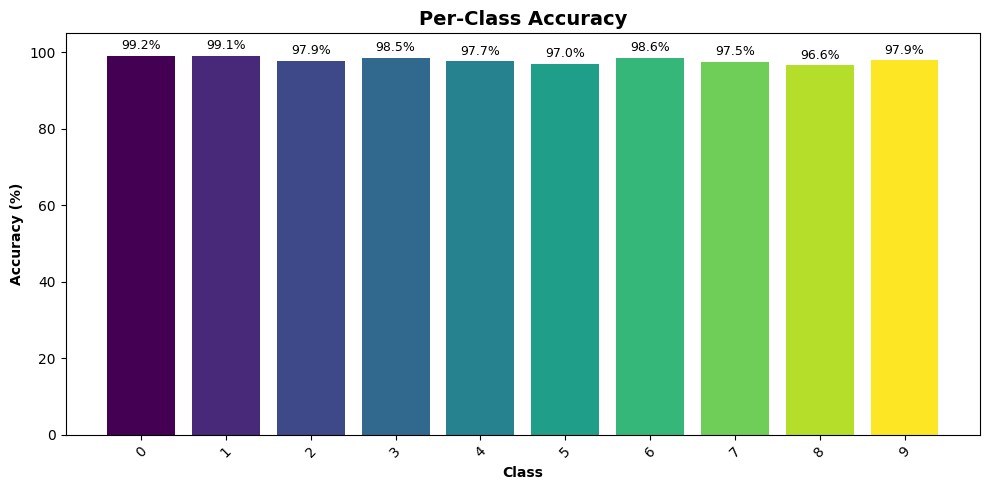

In [10]:
classes = range(0, 10)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(confusion, cmap='Blues')

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Count', fontweight='bold')

# Labels and ticks
ax.set_xticks(range(10))
ax.set_yticks(range(10))
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.set_yticklabels(classes)
ax.set_xlabel('Predicted Label', fontweight='bold', fontsize=12)
ax.set_ylabel('True Label', fontweight='bold', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=16, fontweight='bold')

# Add text annotations
for i in range(10):
    for j in range(10):
        text = ax.text(j, i, str(confusion[i, j]),
                      ha="center", va="center", color="black" if confusion[i, j] < confusion.max()/2 else "white")

plt.tight_layout()
plt.show()

# Per-class accuracy bar chart
fig, ax = plt.subplots(figsize=(10, 5))

# Compute per-class accuracy
per_class_accuracy = []
for i in range(len(classes)):
    class_total = confusion[i].sum()
    acc = confusion[i, i] / class_total if class_total > 0 else 0.0
    per_class_accuracy.append(acc * 100)

colors = plt.cm.viridis(np.linspace(0, 1, len(classes)))
ax.bar(range(len(classes)), per_class_accuracy, color=colors)

# Labels and formatting
ax.set_xlabel('Class', fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontweight='bold')
ax.set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(classes)))
ax.set_xticklabels(classes, rotation=45)
ax.set_ylim(0, 105)

for i, acc in enumerate(per_class_accuracy):
    ax.text(i, acc + 1, f"{acc:.1f}%", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

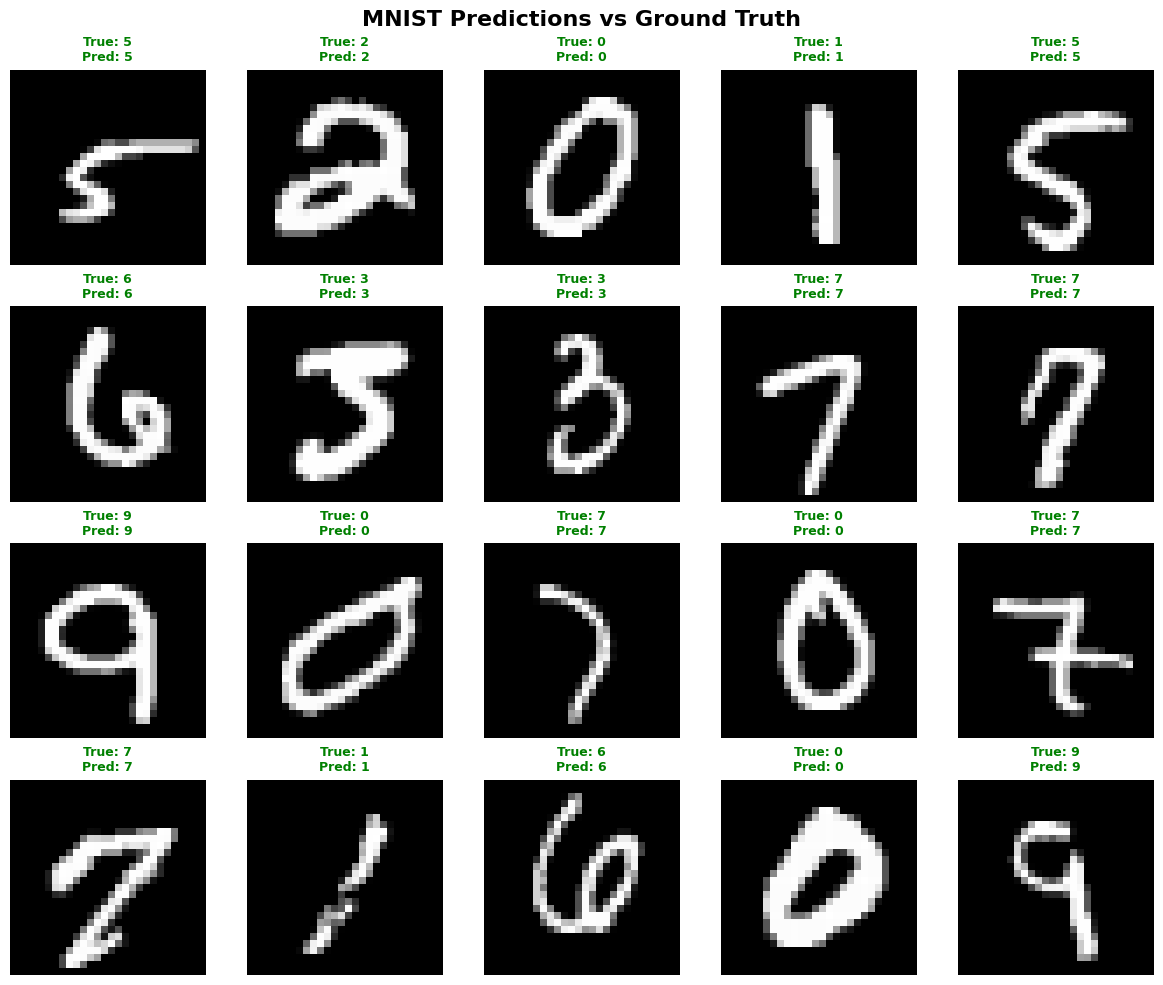

In [11]:
# Show prediction examples
def show_predictions(model, data, labels, classes, device="cpu", num_images=20):
    model.eval()

    indices = np.random.choice(len(data), num_images, replace=False)

    # Model input (already flattened for MLP)
    sample_x = Tensor(
        data[indices].astype(np.float32),
        requires_grad=False,
        device=device
    )
    sample_y = labels[indices].astype(int)

    with no_grad():
        logits = model(sample_x)
        logits.to("cpu")
        pred = logits.data.argmax(axis=1).astype(int)

    fig, axes = plt.subplots(4, 5, figsize=(12, 10))
    fig.suptitle("MNIST Predictions vs Ground Truth", fontsize=16, fontweight="bold")

    for idx, ax in enumerate(axes.flat):
        # Reshape flattened vector back to image
        img = data[indices[idx]].reshape(28, 28)

        ax.imshow(img, cmap="gray")
        ax.axis("off")

        true_label = classes[sample_y[idx]]
        pred_label = classes[pred[idx]]
        color = "green" if true_label == pred_label else "red"

        ax.set_title(
            f"True: {true_label}\nPred: {pred_label}",
            fontsize=9,
            fontweight="bold",
            color=color
        )

    plt.tight_layout()
    plt.show()

show_predictions(model, val_data, val_labels, classes, device=device)